In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

import numpy as onp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami
from vittles import solver_lib

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# np.random.seed(53453)

# load data

In [3]:
data_file = '../../../../fastStructure/test/testdata.npz'
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# Load fits

In [5]:
import os
import re

In [6]:
fits_dir = '../fits/fits_20201106/'
filenames = 'testdata_fit_alpha*'

In [7]:
files = [f for f in os.listdir(fits_dir) if re.match(filenames, f)]

In [8]:
files

['testdata_fit_alpha1.0.npz',
 'testdata_fit_alpha4.5.npz',
 'testdata_fit_alpha8.5.npz',
 'testdata_fit_alpha5.5.npz',
 'testdata_fit_alpha9.5.npz',
 'testdata_fit_alpha3.0.npz',
 'testdata_fit_alpha10.5.npz',
 'testdata_fit_alpha6.5.npz',
 'testdata_fit_alpha2.0.npz',
 'testdata_fit_alpha7.5.npz',
 'testdata_fit_alpha9.0.npz',
 'testdata_fit_alpha5.0.npz',
 'testdata_fit_alpha8.0.npz',
 'testdata_fit_alpha4.0.npz',
 'testdata_fit_alpha1.5.npz',
 'testdata_fit_alpha7.0.npz',
 'testdata_fit_alpha11.0.npz',
 'testdata_fit_alpha2.5.npz',
 'testdata_fit_alpha6.0.npz',
 'testdata_fit_alpha10.0.npz',
 'testdata_fit_alpha3.5.npz']

### load first fit to get metadata

In [9]:
_, vb_params_paragami, meta_data = \
    paragami.load_folded(fits_dir + files[0])

# logitnormal parameters
gh_deg = int(meta_data['gh_deg'])
gh_loc, gh_weights = hermgauss(gh_deg)

gh_loc = np.array(gh_loc)
gh_weights = np.array(gh_weights)

use_logitnormal_sticks = meta_data['use_logitnormal_sticks'] == 1

# prior parameters for population beta
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

prior_params_dict['allele_prior_alpha'] = np.array(meta_data['allele_prior_alpha'])
prior_params_dict['allele_prior_beta'] = np.array(meta_data['allele_prior_beta'])

### Load all fits

In [10]:
vb_refit_list = []
alpha_vec = onp.zeros(len(files))

for i in range(len(files)): 
    
    print('loading fit from: ', files[i])
    
    # load fit
    vb_params_dict, vb_params_paragami, meta_data = \
        paragami.load_folded(fits_dir + files[i])
    
    # check KL
    prior_params_dict['dp_prior_alpha'] = np.array(meta_data['dp_prior_alpha'])
    
    kl = structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                                gh_loc, gh_weights)
    
    assert np.abs(kl - meta_data['final_kl']) < 1e-8
    
    # save alpha and fitted parametrs
    alpha_vec[i] = meta_data['dp_prior_alpha']
    vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
    
alpha_vec = np.array(alpha_vec)
vb_refit_list = np.array(vb_refit_list)

loading fit from:  testdata_fit_alpha1.0.npz
loading fit from:  testdata_fit_alpha4.5.npz
loading fit from:  testdata_fit_alpha8.5.npz
loading fit from:  testdata_fit_alpha5.5.npz
loading fit from:  testdata_fit_alpha9.5.npz
loading fit from:  testdata_fit_alpha3.0.npz
loading fit from:  testdata_fit_alpha10.5.npz
loading fit from:  testdata_fit_alpha6.5.npz
loading fit from:  testdata_fit_alpha2.0.npz
loading fit from:  testdata_fit_alpha7.5.npz
loading fit from:  testdata_fit_alpha9.0.npz
loading fit from:  testdata_fit_alpha5.0.npz
loading fit from:  testdata_fit_alpha8.0.npz
loading fit from:  testdata_fit_alpha4.0.npz
loading fit from:  testdata_fit_alpha1.5.npz
loading fit from:  testdata_fit_alpha7.0.npz
loading fit from:  testdata_fit_alpha11.0.npz
loading fit from:  testdata_fit_alpha2.5.npz
loading fit from:  testdata_fit_alpha6.0.npz
loading fit from:  testdata_fit_alpha10.0.npz
loading fit from:  testdata_fit_alpha3.5.npz


In [11]:
# for convencience, sort the alphas 
_indx = np.argsort(alpha_vec)
alpha_vec = alpha_vec[_indx]
vb_refit_list = vb_refit_list[_indx]

# Define the initial fit

In [12]:
indx0 = 5

alpha0 = alpha_vec[indx0]
print(alpha0)

vb_opt = vb_refit_list[indx0]
vb_opt_dict = vb_params_paragami.fold(vb_refit_list[indx0], free = True)

3.5


### Plot initial fit

In [13]:
def plot_e_ind_admix(vb_params_dict): 
    e_ind_admix = plotting_utils.get_vb_expectations(vb_params_dict, gh_loc, gh_weights)[0]
    
    # get large clusters
    top_clusters = np.argsort(- e_ind_admix.sum(0))

    # we color the top clusters
    # all else is grey
    n_clusters_plot = 3
    import colorsys
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,n_clusters_plot+1)[:-1]]

    colors_plus_grey = ['grey'] * e_ind_admix.shape[1]

    for i in range(n_clusters_plot): 
        colors_plus_grey[top_clusters[i]] = colors[i]
        
    # re-order individuals for better plotting
    indx = data_utils.cluster_admix_get_indx(e_ind_admix)
    
    # plot!
    f, axarr = plt.subplots(1, 1, figsize=(6, 3))
    plotting_utils.plot_admixture(e_ind_admix[indx], axarr, colors = colors_plus_grey);

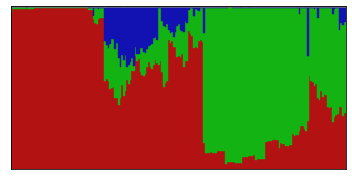

In [14]:
plot_e_ind_admix(vb_opt_dict)

# Define sensitivity object

In [15]:
# initial prior alpha
use_free_alpha = True
prior_alpha0 = prior_params_paragami['dp_prior_alpha'].flatten(alpha0, 
                                                              free = use_free_alpha)

In [16]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['dp_prior_alpha'] = alpha
    
    return structure_model_lib.get_kl(g_obs, vb_params_dict, _prior_params_dict,
                    gh_loc = gh_loc, gh_weights = gh_weights)


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['dp_prior_alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])


### Get hessian solver

In [17]:
# define preconditioner
cg_precond = lambda v : get_mfvb_cov_matmul(v, vb_opt_dict,
                                            vb_params_paragami,
                                            return_sqrt = False, 
                                            return_info = True)

### Compute VB sensitivity derivatives

In [18]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        prior_alpha0, 
                                                        cg_precond=cg_precond)

Compiling ...
Compile time: 134.205sec



# Get linear reponse predictions

In [19]:
lr_list = []

for alpha in alpha_vec: 
    
    alpha_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha,
                                                                 free = use_free_alpha)
    
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(alpha_pert))


# Number of clusters

In [20]:
import numpy as onp

In [21]:
lr_e_num_clusters_vec = onp.zeros(len(alpha_vec))
refit_e_num_clusters_vec = onp.zeros(len(alpha_vec))

for i in range(len(alpha_vec)): 
    
    # get dictionaries
    refit_dict = vb_params_paragami.fold(vb_refit_list[i], free = True)
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    
    # get posterior expectations
    refit_e_ind_admix = plotting_utils.get_vb_expectations(refit_dict, gh_loc, gh_weights)[0]
    lr_e_ind_admix = plotting_utils.get_vb_expectations(lr_dict, gh_loc, gh_weights)[0]
    
    # get number of clusters
    refit_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(refit_e_ind_admix)
    lr_e_num_clusters_vec[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)


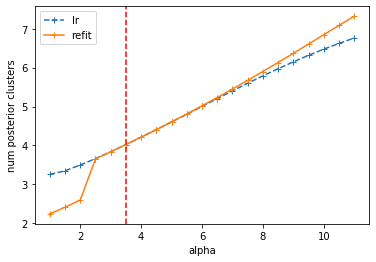

In [22]:
plt.plot(alpha_vec, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_vec, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(alpha0, color = 'red', linestyle = 'dashed')

# Start from a different alpha

6.0


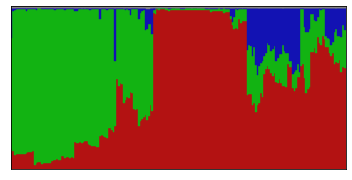

In [23]:
indx0 = 10

alpha1 = alpha_vec[indx0]
print(alpha1)

vb_opt = vb_refit_list[indx0]
vb_opt_dict = vb_params_paragami.fold(vb_refit_list[indx0], free = True)

plot_e_ind_admix(vb_opt_dict)

In [24]:
# reset sensitivity derivatives 

t0 = time.time()
vb_sens.set_derivatives(vb_opt, 
                        prior_params_paragami['dp_prior_alpha'].flatten(alpha1, 
                                                              free = use_free_alpha))
print(time.time() - t0)

38.11411094665527


In [25]:
# get new predictions

lr_e_num_clusters_vec1 = onp.zeros(len(alpha_vec))

for i in range(len(alpha_vec)): 
    
    # get lr predicted parameters
    alpha_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha_vec[i],
                                                                 free = use_free_alpha)
    
    lr_free = vb_sens.predict_opt_par_from_hyper_par(alpha_pert)
    
    # fold 
    lr_dict = vb_params_paragami.fold(lr_free, free = True)
    
    # get number of clusters
    lr_e_ind_admix = plotting_utils.get_vb_expectations(lr_dict, gh_loc, gh_weights)[0]
    lr_e_num_clusters_vec1[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)

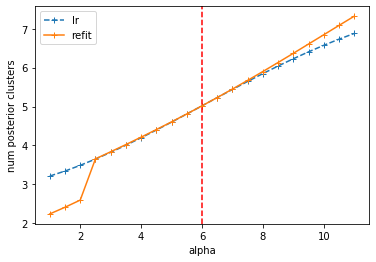

In [26]:
plt.plot(alpha_vec, lr_e_num_clusters_vec2, '+--')
plt.plot(alpha_vec, refit_e_num_clusters_vec, '+-')


plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(alpha1, color = 'red', linestyle = 'dashed')

# Start from a different alpha (again)

9.5


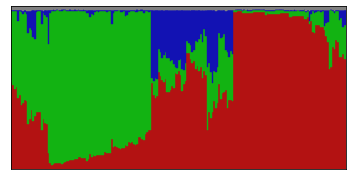

In [27]:
indx0 = 17

alpha2 = alpha_vec[indx0]
print(alpha2)

vb_opt = vb_refit_list[indx0]
vb_opt_dict = vb_params_paragami.fold(vb_refit_list[indx0], free = True)

plot_e_ind_admix(vb_opt_dict)

In [28]:
# reset sensitivity derivatives 

t0 = time.time()
vb_sens.set_derivatives(vb_opt, 
                        prior_params_paragami['dp_prior_alpha'].flatten(alpha2, 
                                                              free = use_free_alpha))
print(time.time() - t0)

43.84511613845825


In [29]:
vb_sens.hyper_par_value0

DeviceArray([2.2512918], dtype=float64)

In [30]:
# get new predictions

lr_e_num_clusters_vec3 = onp.zeros(len(alpha_vec))

for i in range(len(alpha_vec)): 
    
    # get lr predicted parameters
    alpha_pert = prior_params_paragami['dp_prior_alpha'].flatten(alpha_vec[i],
                                                                 free = use_free_alpha)
    
    lr_free = vb_sens.predict_opt_par_from_hyper_par(alpha_pert)
    
    # fold 
    lr_dict = vb_params_paragami.fold(lr_free, free = True)
    
    # get number of clusters
    lr_e_ind_admix = plotting_utils.get_vb_expectations(lr_dict, gh_loc, gh_weights)[0]
    lr_e_num_clusters_vec2[i] = cluster_quantities_lib.get_e_num_clusters_from_ez(lr_e_ind_admix)

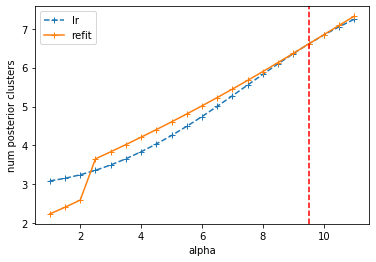

In [31]:
plt.plot(alpha_vec, lr_e_num_clusters_vec2, '+--')
plt.plot(alpha_vec, refit_e_num_clusters_vec, '+-')


plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(alpha2, color = 'red', linestyle = 'dashed')

# the final plot!

NameError: name 'lr_e_num_clusters_vec1' is not defined

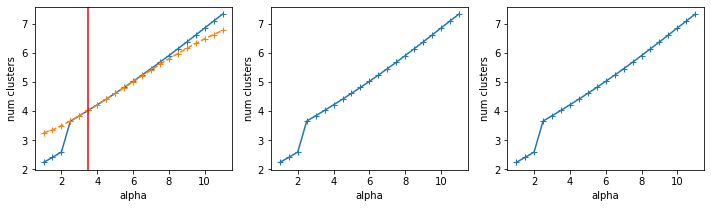

In [42]:
fig, axarr = plt.subplots(1, 3, figsize = (12, 3))

for i in range(3): 
    axarr[i].plot(alpha_vec, refit_e_num_clusters_vec, '+-')
    axarr[i].set_xlabel('alpha')
    axarr[i].set_ylabel('num clusters')

    
axarr[0].plot(alpha_vec, lr_e_num_clusters_vec, '+--')
axarr[0].axvline(alpha0, color = 'red')

axarr[1].plot(alpha_vec, lr_e_num_clusters_vec1, '+--')
axarr[1].axvline(alpha1, color = 'red')

In [31]:
# for loading in an already saved hessian inverse solution ... 

# class VBSensitivity(object): 
#     def __init__(self, lr_file, opt_par_value, hyper_par_value0): 
#         self.dinput_dhyper = np.load(lr_file)
        
#         self.opt_par_value = opt_par_value
#         self.hyper_par_value0 = hyper_par_value0
        
#     def predict_opt_par_from_hyper_par(self, hyper_par_value):
#         delta = (hyper_par_value - self.hyper_par_value0)

#         if len(self.dinput_dhyper.shape) == 1:
#             self.dinput_dhyper = np.expand_dims(self.dinput_dhyper, 1)

#         return np.dot(self.dinput_dhyper, delta) + self.opt_par_value

In [32]:
# load_lr_der = True
# if load_lr_der: 
#     lr_file = fit_dir + 'alpha_sens_nobs{}_nloci{}_npop{}_alpha{}.npy'.format(n_obs, 
#                                                                           n_loci, 
#                                                                           n_pop, 
#                                                                           alpha0)
#     vb_sens = VBSensitivity(lr_file, vb_opt, prior_alpha0)
# else: 
#     vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
#                                                         vb_opt,
#                                                         prior_alpha0, 
#                                                         cg_precond=cg_precond)

In [33]:
# def e_num_clusters_from_ez(vb_params_dict, gh_loc, gh_weights): 
#     e_log_sticks, e_log_1m_sticks, \
#         e_log_pop_freq, e_log_1m_pop_freq = \
#             structure_model_lib.get_moments_from_vb_params_dict(vb_params_dict,
#                                     gh_loc = gh_loc,
#                                     gh_weights = gh_weights)
#     e_log_cluster_probs = \
#         modeling_lib.get_e_log_cluster_probabilities_from_e_log_stick(
#                             e_log_sticks, e_log_1m_sticks)
    
    
#     prod_ez = 1.
#     for l in range(g_obs.shape[1]):
#         _, e_z_l = structure_model_lib.get_optimal_ezl(g_obs[:, l],
#                                 e_log_pop_freq[l], e_log_1m_pop_freq[l],
#                                 e_log_cluster_probs)
        
#         prod_ez *= (1 - e_z_l).prod(2).prod(0)
                
#     return prod_ez